# 1. Data Description # 

## Loading and reading data files ##

In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Players Dataset ##

In [2]:
players <- read_csv("https://raw.githubusercontent.com/tiffyue/dsci_100_project/refs/heads/main/data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


### Data Description ###

The dataset reads in players.csv and compiles player's characteristics and interactions. There are 196 made observations across 7 different columns:

1. experience
   - describes the aptitude of the player
   - character type
   - the order of experience is ambiguous; Veteran and Pro are similar skillsets
2. subscribe
   - Indicates if the player is subscribed to the game
   - logical type
3. hashedEmail
   - a unique generated email for the player to use
   - character type
   - must account for long characters in visualizations
4. played_hours
   - how much time the player spent on the game
   - double type
5. name
    - username of player
    - character type
    - unsure if it's a new randomly generated name
6. gender
    - gender of player
    - character type
7. Age
    - age of player
    - double type
    - might be confusing to interpret age with decimals

# 2. Question #

## Broad Question ##

_What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?_

## Specific Question ##

### _Can age and played hours in PLAIcraft predict the likelihood of the players subscribing to a game-related newsletter?_ ###

The predictor variables "Age" and "played_hours" can help visualize the relationship of user interactions to subscribed players. I will wrangle the dataset where subscrive is treated as a factor. Then I can use the knn classification model to observe the nearest neighbor and determine subscription status.


# 3. Exploratory Analysis #

In [3]:
# Wrangling dataset to compensate for missing observations in Age
players_data <- players |>
     filter(!is.na(Age)) 


# mean of all the quantitative data (played_hours and Age)

mean_players <- players_data |>
    select(played_hours, Age) 
    

mean_players

played_hours,Age
<dbl>,<dbl>
30.3,9
3.8,17
0.0,17
⋮,⋮
0.3,22
0.0,17
2.3,17


| Quantitative Player Data  | Mean
|--------------|-----
| played_hours | 5.90
| Age          | 20.5

`summarise()` has grouped output by 'experience', 'subscribe'. You can override
using the `.groups` argument.


experience,subscribe,played_hours,Age
<chr>,<lgl>,<dbl>,<dbl>
Regular,TRUE,0.3,8
Pro,TRUE,30.3,9
Regular,TRUE,3.6,10
⋮,⋮,⋮,⋮
Beginner,FALSE,0.2,37
Veteran,TRUE,0.2,38
Regular,TRUE,18.5,49


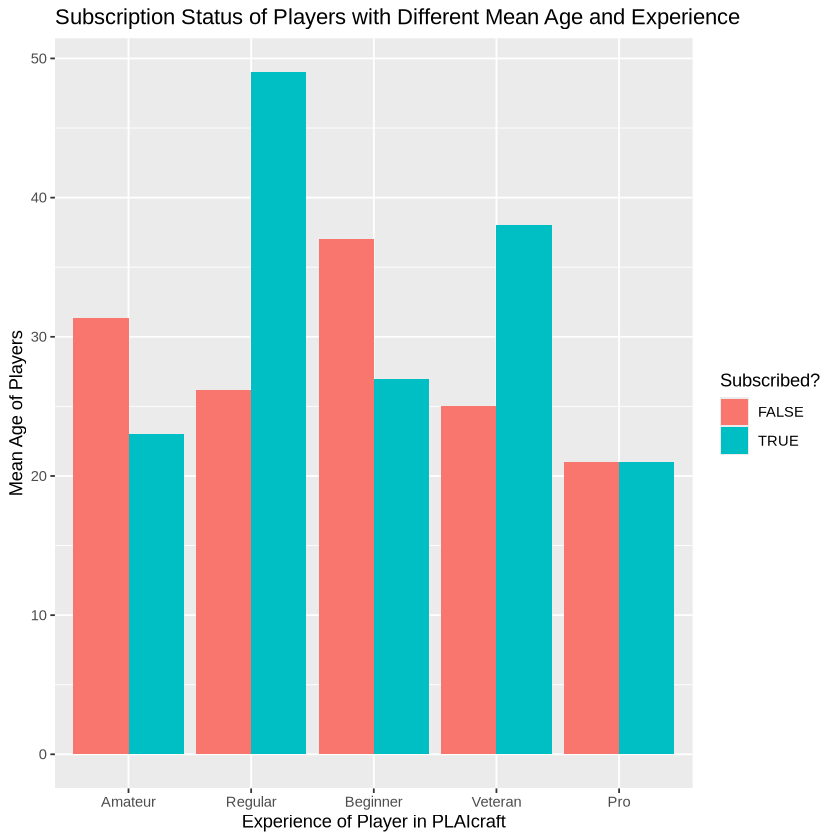

In [4]:
# 1: Explore how the experience of the player based on mean Age and how it relates to subscription status

mean_age_players <- players_data |>
    group_by(experience, subscribe, played_hours) |>
    summarize(Age = mean(Age, na.rm = TRUE)) |>
    arrange(Age)

mean_age_players


player_rank_subscription <- mean_age_players |>
    ggplot(aes(x = fct_reorder(experience, played_hours, .desc = TRUE), y = Age, fill = as_factor(subscribe))) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(x = "Experience of Player in PLAIcraft", y = "Mean Age of Players",
         fill = "Subscribed?", title = "Subscription Status of Players with Different Mean Age and Experience")

player_rank_subscription

#### Analysis # 1 ####

"Regular" are the oldest amongst the mean age and has highest subscriptions. Pros are around equal, but it seems that players in the 20-40 range are more likely to not subscribe other than "Veteran" 

`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


experience,subscribe,played_hours
<chr>,<lgl>,<dbl>
Regular,TRUE,23.400000
Amateur,TRUE,8.277778
Pro,TRUE,3.766667
⋮,⋮,⋮
Veteran,FALSE,0.50666667
Amateur,FALSE,0.36666667
Regular,FALSE,0.02857143


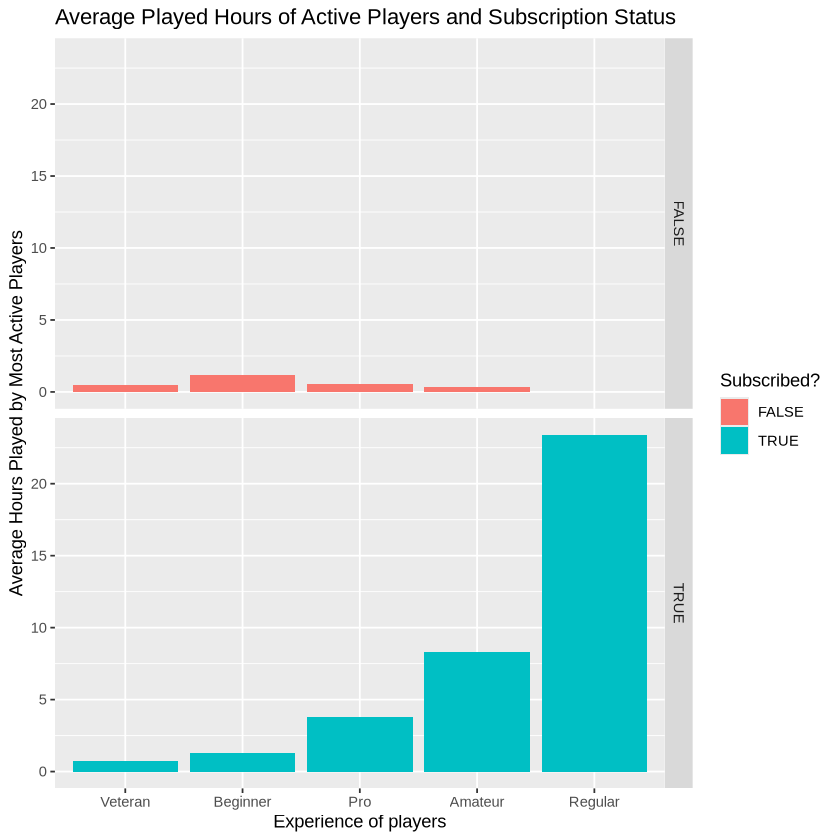

In [5]:
# 2: Explore the average time a player interacts with the game based on their experience to determine subscription status
active_players <- players_data |>
    group_by(experience, subscribe) |>
    summarize(played_hours = mean(played_hours, na.rm = TRUE)) |>
    arrange(desc(played_hours))

active_players

average_time_players <- active_players |>
    ggplot(aes(x = fct_reorder(experience,played_hours),  y= played_hours,fill = as_factor(subscribe))) +
    geom_bar(stat = "identity") +
    facet_grid(rows = vars(subscribe)) +
    labs(x = "Experience of players", y = "Average Hours Played by Most Active Players", fill = "Subscribed?",
        title = "Average Played Hours of Active Players and Subscription Status") 
      
average_time_players

#### Analysis # 2 ####

Regular players average the most hours and have the highest subscription density. Some novice players log long hours, often subscribing, except "Beginners" who mostly don't. Experienced players average fewer hours than some novices and are less subscribed.

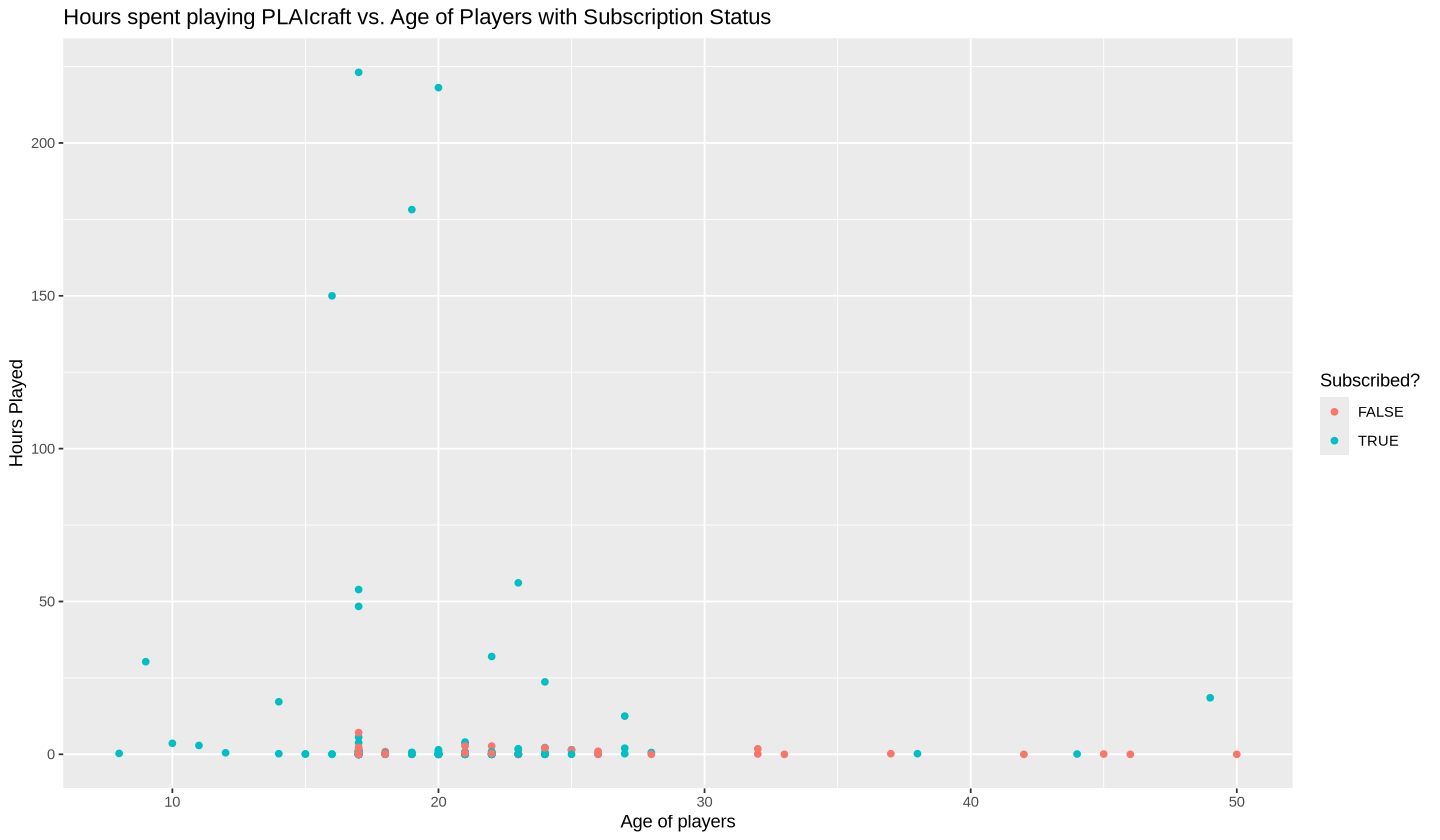

In [6]:
# 3: Exploring the Relationship between Age and played_hours to determine subscription status
options(repr.plot.width = 12, repr.plot.height = 7)

players_age_hours_plot <- players_data |>
    ggplot(aes(x = Age,  y= played_hours ,color = as_factor(subscribe))) +
    geom_point() +
    labs(x = "Age of players", y = "Hours Played", color = "Subscribed?",
        title = "Hours spent playing PLAIcraft vs. Age of Players with Subscription Status") 
      
players_age_hours_plot

#### Analysis # 3 ####

Most players are around 10 - 30 years old and has the highest recored hours played that exceeds 150 hours. Most of the plots are blue, indicating that a marjority of the players are subscribed.  

`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


experience,subscribe,played_hours
<chr>,<lgl>,<dbl>
Regular,TRUE,223.1
Amateur,TRUE,150.0
Pro,TRUE,30.3
⋮,⋮,⋮
Amateur,FALSE,2.3
Pro,FALSE,1.7
Regular,FALSE,0.1


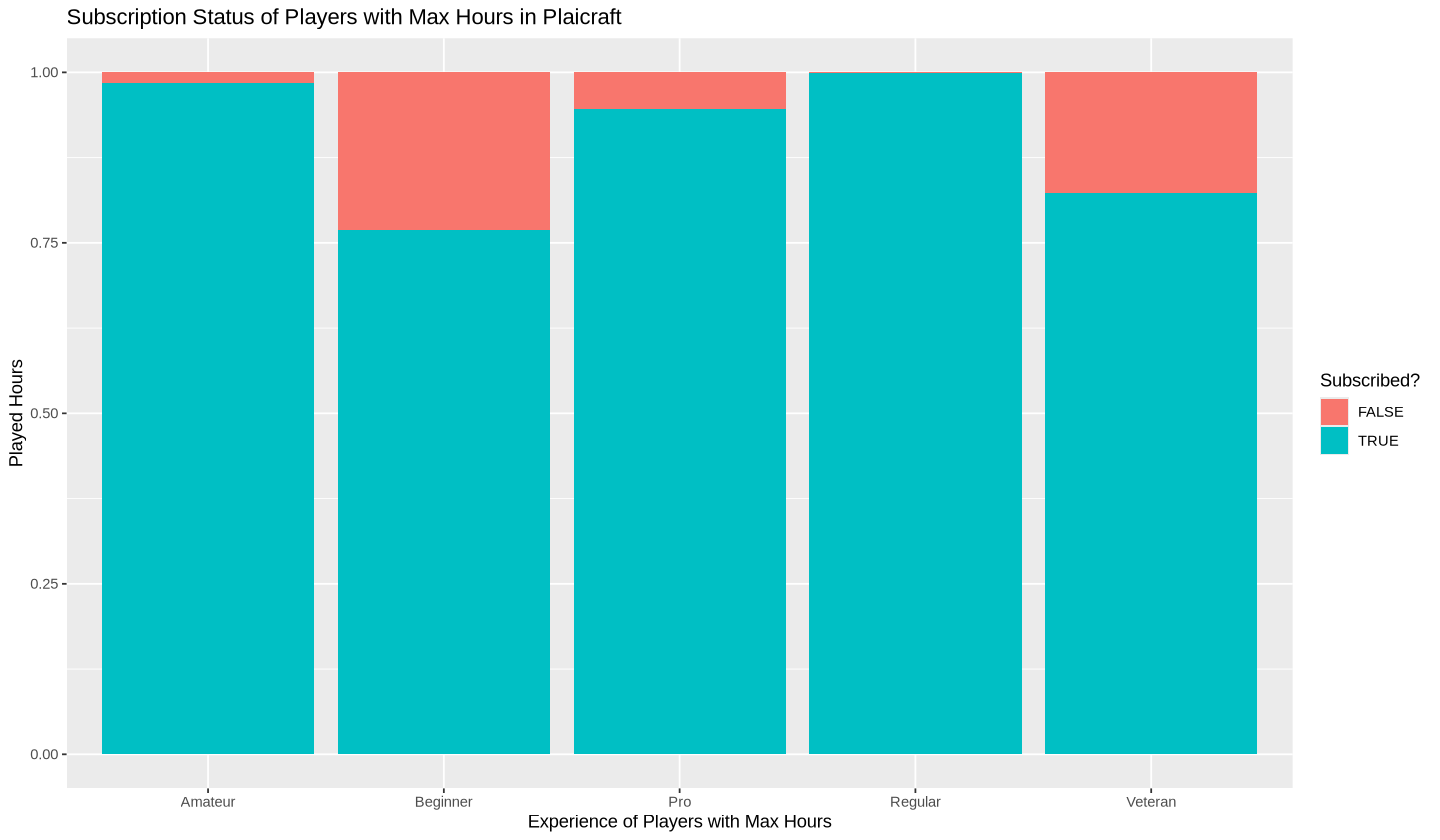

In [7]:
# 4 Comparing the subscription status between players with max hours in subscription status

max_players <- players_data |>
    group_by(experience, subscribe) |>
    summarize(played_hours = max(played_hours, na.rm = TRUE)) |>
    arrange(desc(played_hours))
    
max_players

max_players_plot <- max_players |>
    ggplot(aes(x = experience, y = played_hours, fill = subscribe)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(x = "Experience of Players with Max Hours", y = "Played Hours", 
         fill = "Subscribed?", title = "Subscription Status of Players with Max Hours in Plaicraft")
max_players_plot

#### Analysis # 4 ####

Regular players with maximum hours are fully subscribed, followed closely by Amateurs and Pros. Beginners and Veterans show some non-subscribers, but they comprise only about 25% of the total.

played_hours,experience,subscribe
<dbl>,<chr>,<lgl>
0.1,Regular,TRUE
0.1,Amateur,TRUE
0.1,Amateur,FALSE
⋮,⋮,⋮
1,Beginner,TRUE
1,Beginner,TRUE
1,Amateur,FALSE


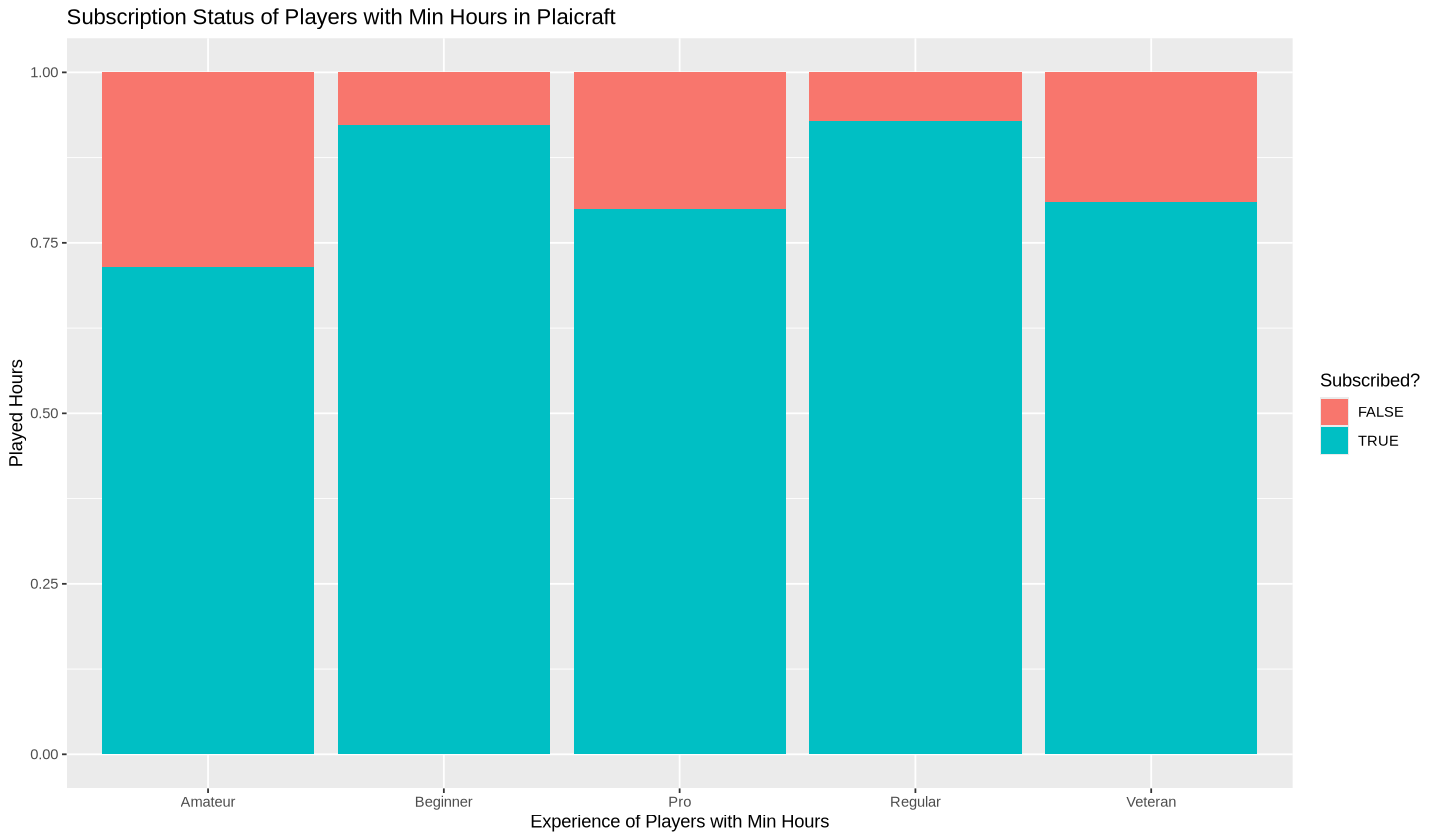

In [8]:
# 5 Comparing the subscription status between players with min hours in subscription status

min_players <- players_data |>
    filter(played_hours > 0 & played_hours <= 1) |>
    select(played_hours, experience, subscribe) |>
    arrange(played_hours) 
       
min_players

min_players_plot <- min_players |>
    ggplot(aes(x = experience, y = played_hours, fill = subscribe)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(x = "Experience of Players with Min Hours", y = "Played Hours", 
         fill = "Subscribed?", title = "Subscription Status of Players with Min Hours in Plaicraft")
min_players_plot

#### Analysis # 5 ####

Beginner and Regular players with minimal hours show high, similar subscription rates. Amateur, Pro, and Veteran players have noticeable unsubscribed segments, with Amateur's distribution being the largest. Unsubscribed players remain around 25% or less of each group.

# 4. Methods and Plans #

Using players.csv, one method to address my question is training a ”knn classification model”  to label new player observations on how likely they will subscribe based on Age and played_hours. It is appropriate since the two predictor variables are numeric and I can wrangle "subscribe" as a factor type. Some assumptions are that the data plot will be heavily scattered and no apparent trend since the data pool is mostly university students, meaning the age of 10 - 30 has more observations. Some weaknesses are that "subscribed" is overrepresented in the dataset as seen in the scatterplot modeling, meaning we need to scale and center the data for "unsubscribed". We will use facet_grid() to also split played_hours vs Age by experience to better visualize the distribution. We will select the model based on the best k value by finding the smallest RMSPE. We will do cross validation using a 5 fold split of the data where training data is 70% and testing is 30%.